In [4]:
%pip install pandas
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 292.8 kB/s eta 0:00:000:00:01m eta 0:00:02
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 254.5 kB/s eta 0:00:00 kB/s eta 0:00:01:02
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl (3.0 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]ow]
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
files = glob.glob("../results/*.csv")
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Convert size to int if not already
df["size"] = df["size"].astype(int)

# Aggregate: get mean and std
summary = df.groupby(["benchmark_name", "allocator_name", "size", "amount"]).agg(
    mean_time=("total_time", "mean"),
    std_time=("total_time", "std")
).reset_index()

summary

,benchmark_name,allocator_name,size,amount,mean_time,std_time
0,basic,dmalloc,1,1000,0.000052,NaN
1,basic,dmalloc,1,2000,0.000063,NaN
2,basic,dmalloc,1,3000,0.000107,NaN
3,basic,dmalloc,1,4000,0.000089,NaN
4,basic,dmalloc,1,5000,0.000162,NaN
...,...,...,...,...,...,...
295,varying_allocs,malloc,0,6000,0.002723,NaN
296,varying_allocs,malloc,0,7000,0.003062,NaN
297,varying_allocs,malloc,0,8000,0.003753,NaN
298,varying_allocs,malloc,0,9000,0.004656,NaN


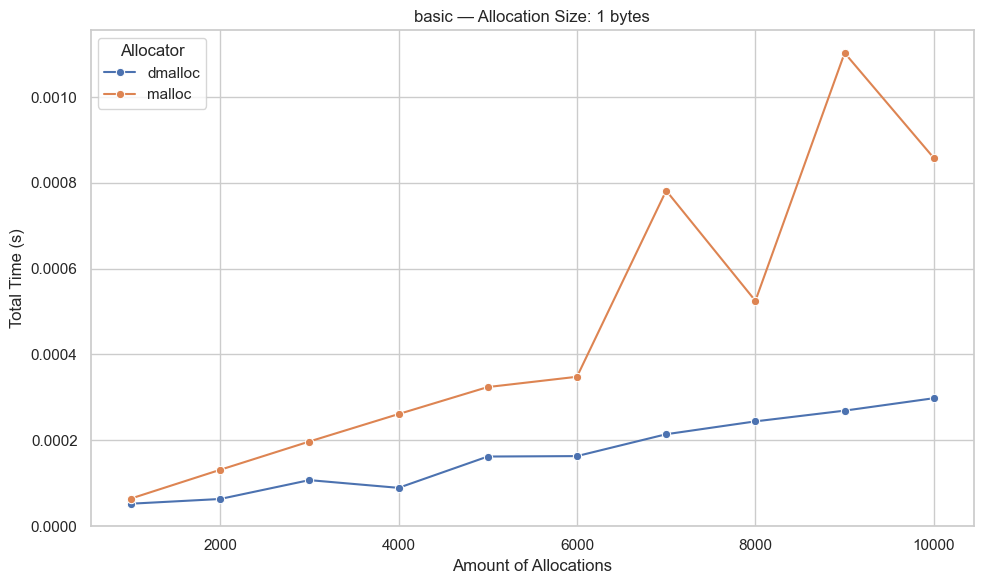

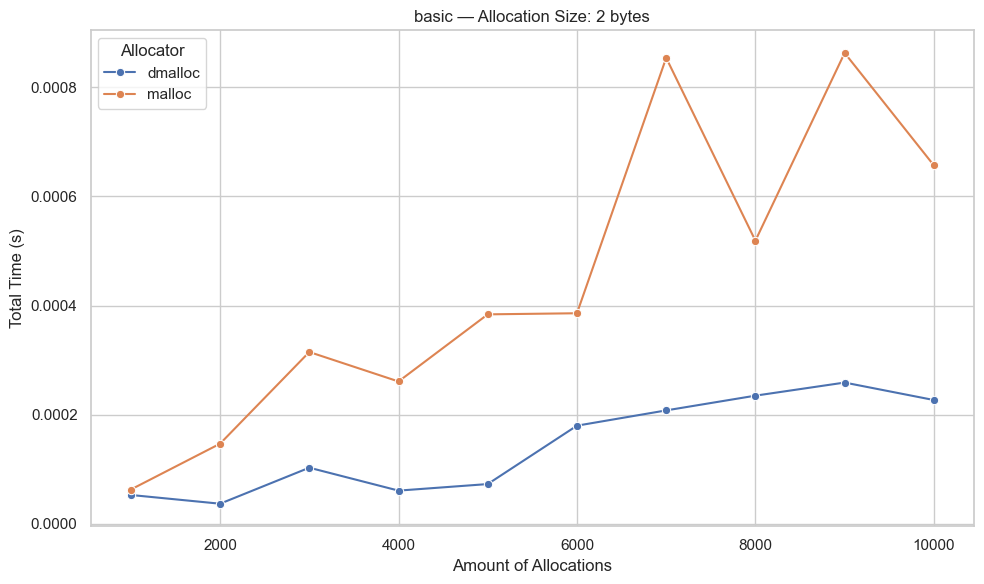

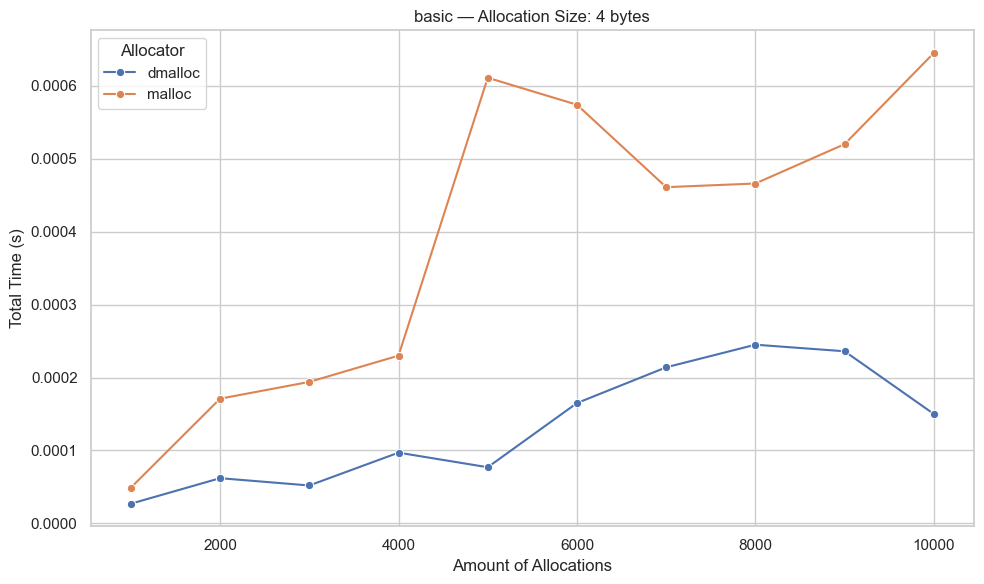

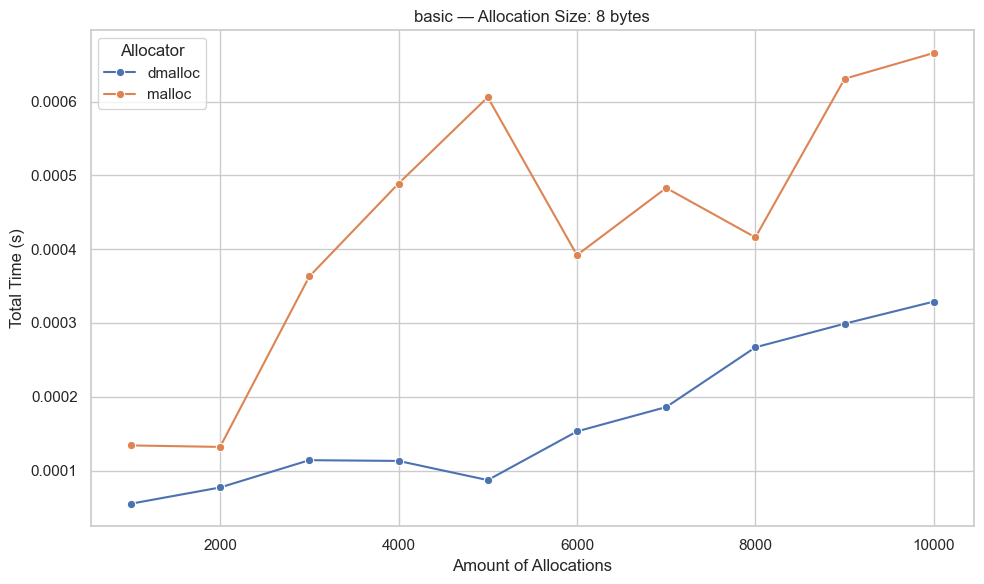

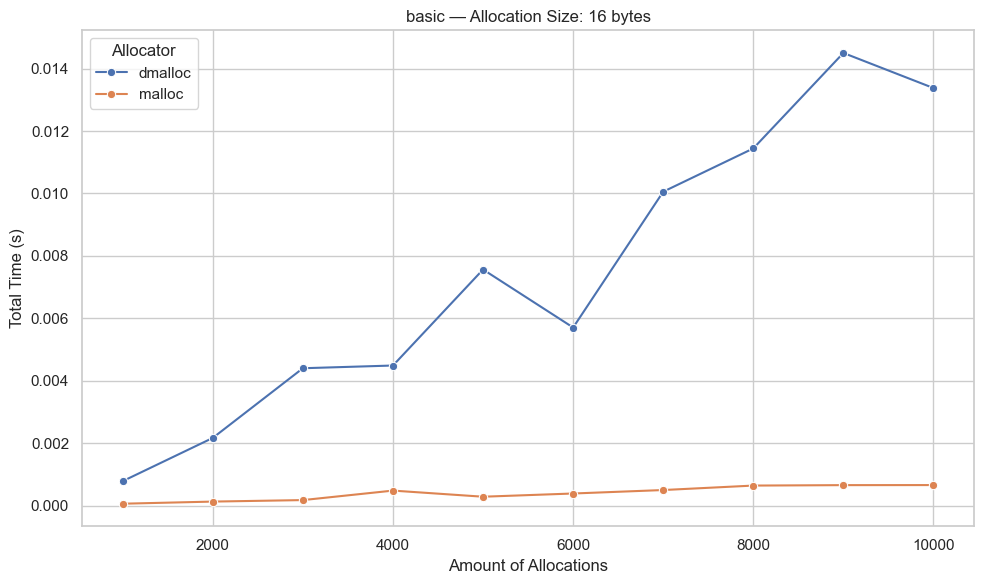

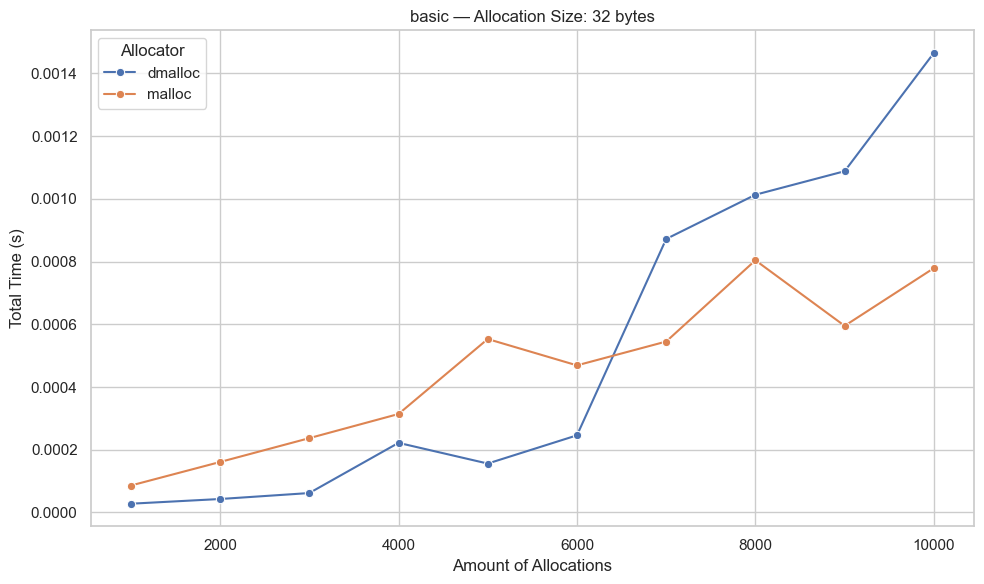

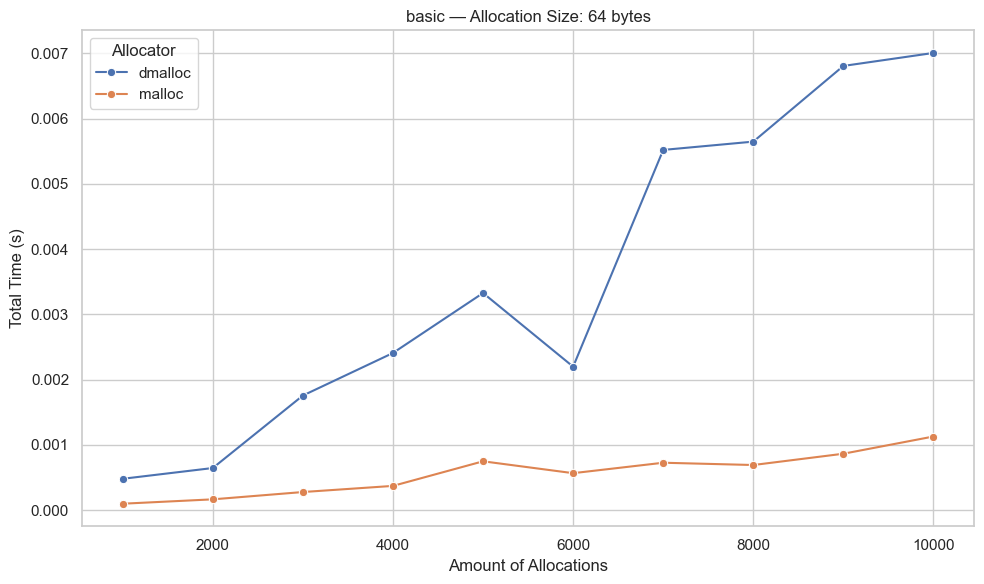

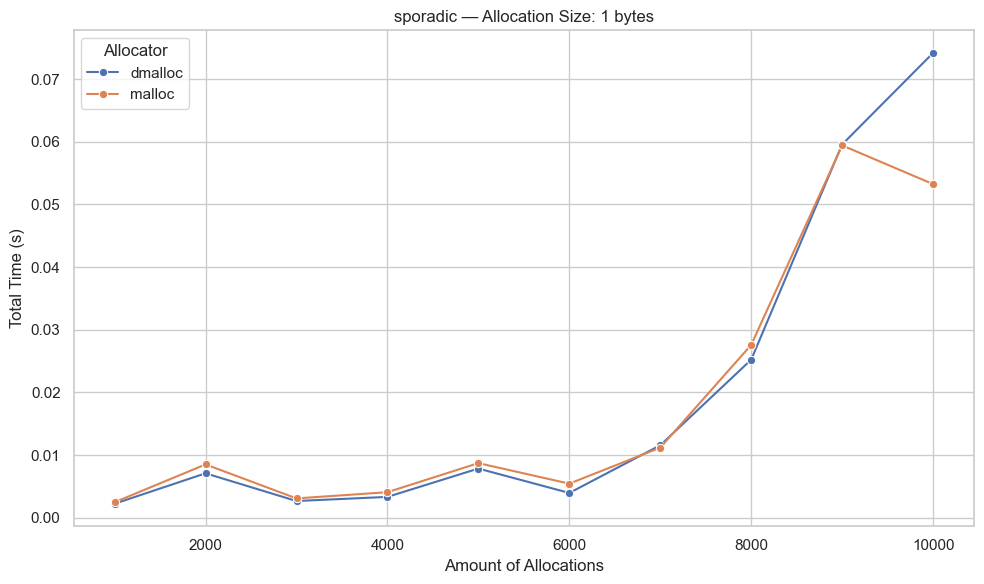

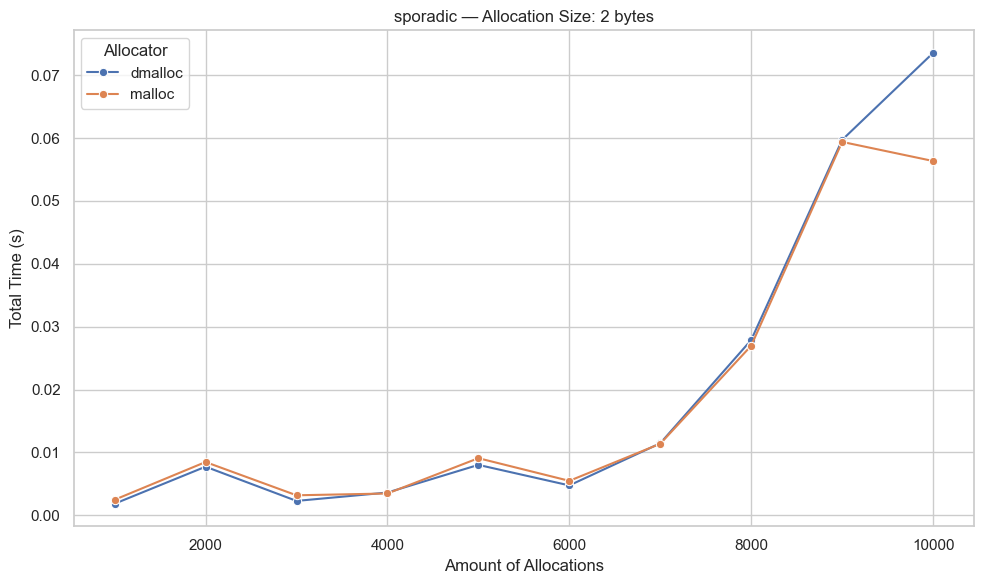

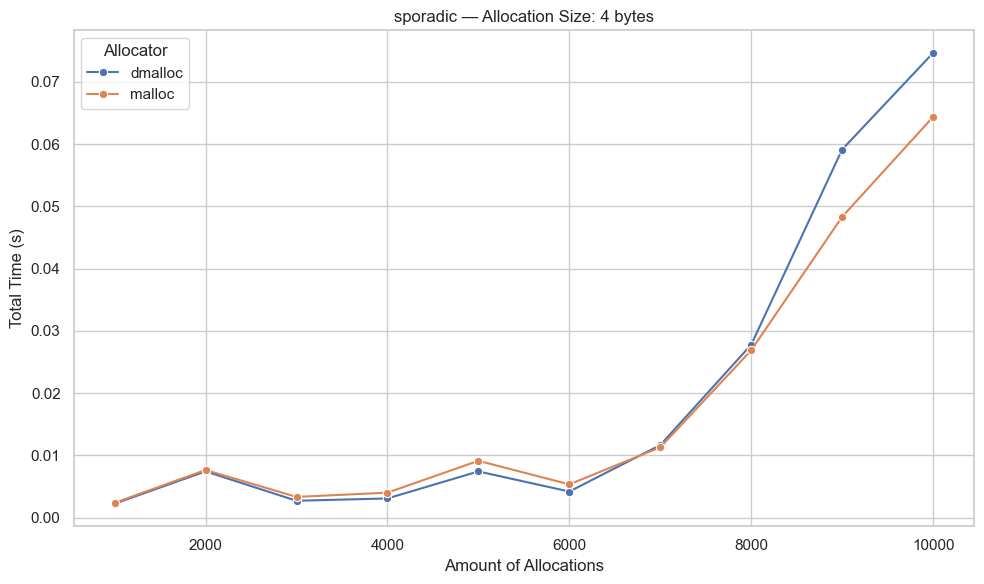

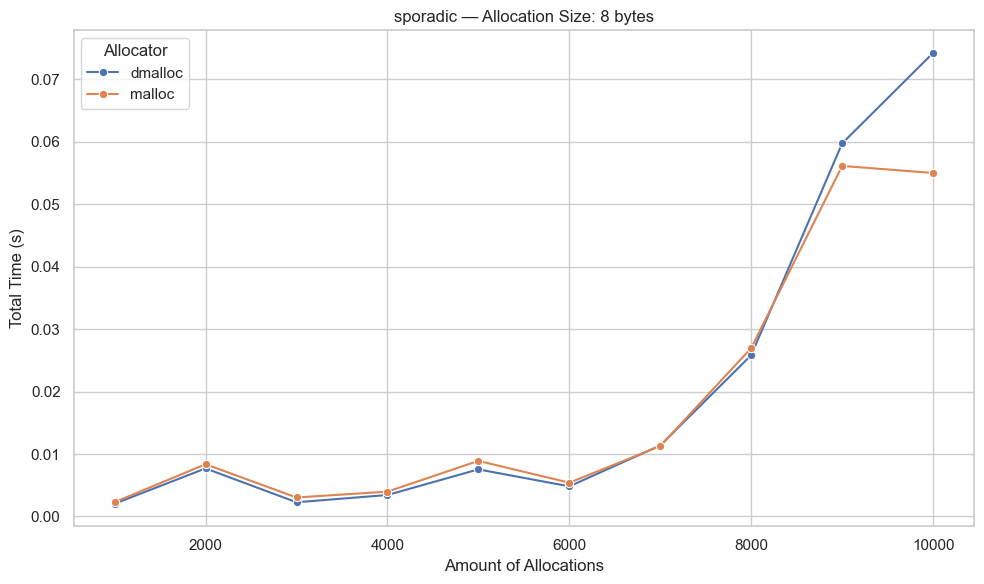

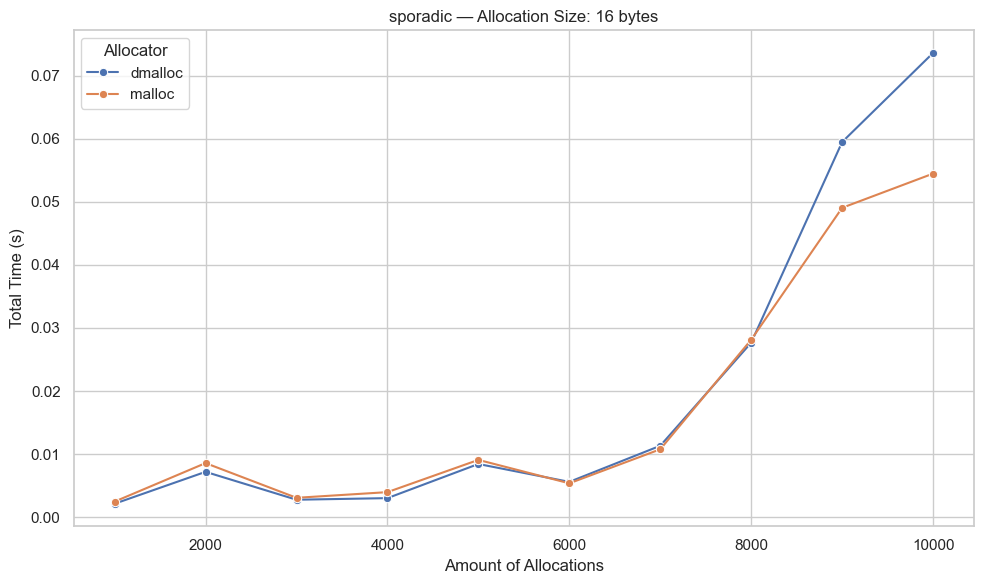

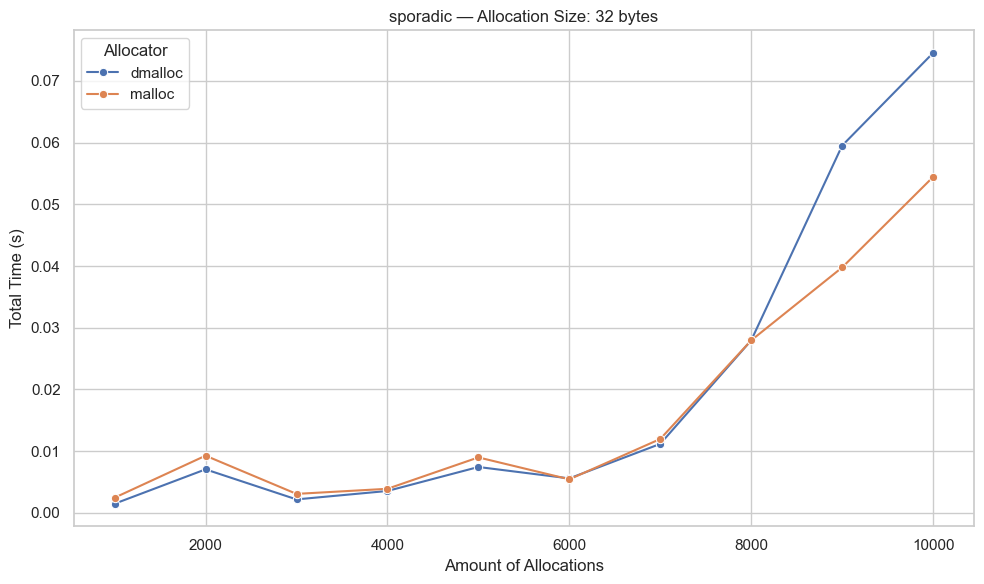

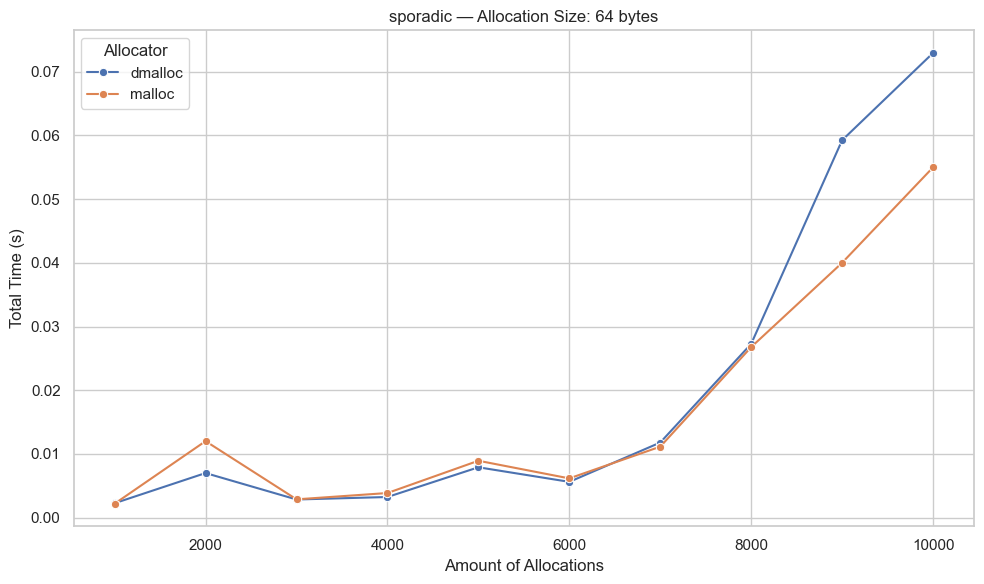

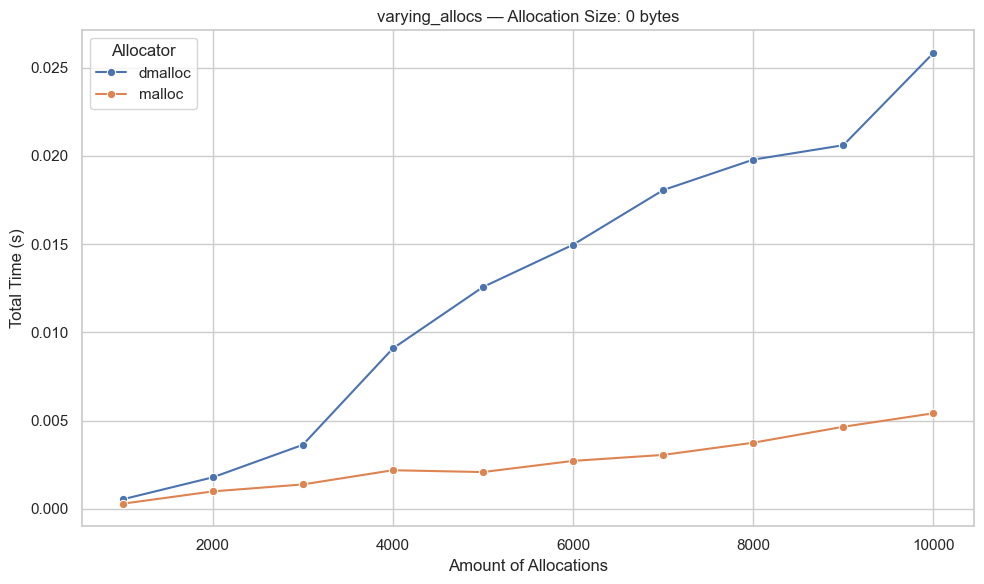

In [3]:
sns.set_theme(style="whitegrid")

for benchmark in summary["benchmark_name"].unique():
    bench_data = summary[summary["benchmark_name"] == benchmark]
    for size in sorted(bench_data["size"].unique()):
        size_data = bench_data[bench_data["size"] == size]

        plt.figure(figsize=(10, 6))
        ax = sns.lineplot(
            data=size_data,
            x="amount",
            y="mean_time",
            hue="allocator_name",
            marker="o"
        )

        # Error bands
        for allocator in size_data["allocator_name"].unique():
            alloc_data = size_data[size_data["allocator_name"] == allocator]
            plt.fill_between(
                alloc_data["amount"],
                alloc_data["mean_time"] - alloc_data["std_time"],
                alloc_data["mean_time"] + alloc_data["std_time"],
                alpha=0.2
            )

        plt.title(f"{benchmark} — Allocation Size: {size} bytes")
        plt.xlabel("Amount of Allocations")
        plt.ylabel("Total Time (s)")
        plt.legend(title="Allocator")
        plt.tight_layout()